In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install transformers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
BASE_PATH = "/content/drive/My Drive/collab/"
# BASE_PATH = "/Users/samir/Dev/projects/MIMIC/"
input_path = BASE_PATH+"MIMIC/DATA/input/"
output_path = BASE_PATH+"MIMIC/DATA/results/"
tmp_path = BASE_PATH+"MIMIC/DATA/processed/"
sys.path.append(BASE_PATH+"TADAT/") 
N_SEEDS=4

In [3]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
from pdb import set_trace
import pandas as pd
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns
import warnings
import pickle
import os

#local
from tadat.pipeline import plots
from tadat.core import data, vectorizer, features, helpers, embeddings, berter,transformer_lms

warnings.filterwarnings("ignore")
sns.set(style="darkgrid")

%matplotlib inline
%load_ext autoreload
%autoreload 2



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
def get_features(data, vocab_size, feature_type, word_vectors=None):
    if feature_type == "BOW-BIN":
        X = features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-FREQ":
        X = features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-BIN":
        X = features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-SUM": 
        X = features.BOE(data, word_vectors,"sum")
    else:
        raise NotImplementedError
    return X
    
def get_BERT_embedding(X, feature_type):
    X_cls, X_pool =  transformer_lms.transformer_encode_batches(X, batchsize=200, device="cuda")
    if feature_type == "BERT-POOL":
        return X_pool
    elif feature_type == "BERT-CLS":
        return X_cls

def get_cached_results(path):
    title = os.path.basename(path)
    group = title[:title.index("_")]
    if group == "gender":
        plot_func = gender_results
    elif group == "ethnicity-binary":
        plot_func = ethnicity_binary_results
    elif group == "ethnicity":
        plot_func = ethnicity_results
    else:
        m = "group [{}] unknown".format(group)
        raise NotImplementedError(m)
    R = list(read_cache(path))    
    R.append(title.replace("_"," x "))
    plot_func(*R)

def read_cache(path):
    X = None
    try:
        with open(path, "rb") as fi:            
            X = pickle.load(fi)
    except FileNotFoundError:
        pass
    return X

def write_cache(path, o):
    with open(path, "wb") as fo:
      pickle.dump(o, fo)

def featurize(df_train, df_test, df_val, x_label, y_label, feature_type, group_label, subgroup, split=0.8):
    df_test_G = df_test[df_test[group_label] == subgroup]
    df_test_O = df_test[df_test[group_label] != subgroup]
    
    print("{}: {} | others: {}".format(subgroup,len(df_test_G),len(df_test_O)))
    #transform the data into the right format
    train = data.read_dataframe(df_train, x_label, y_label)
    test_G = data.read_dataframe(df_test_G, x_label, y_label)
    test_O = data.read_dataframe(df_test_O, x_label, y_label)
    test = data.read_dataframe(df_test, x_label, y_label)

    #get vectorized train/test data 
    train_X = data.getX(train)
    test_X_G = data.getX(test_G)
    test_X_O = data.getX(test_O)
    test_X = data.getX(test)
    
    train_X, word_vocab = vectorizer.docs2idx(train_X)
    test_X_G,_ = vectorizer.docs2idx(test_X_G, word_vocab)
    test_X_O,_ = vectorizer.docs2idx(test_X_O, word_vocab)
    test_X,_ = vectorizer.docs2idx(test_X, word_vocab)
    
    #vectorize labels
    train_Y = data.getY(train)
    test_Y_G = data.getY(test_G) 
    test_Y_O = data.getY(test_O)   
    test_Y = data.getY(test)   
    
    label_vocab = vectorizer.get_labels_vocab(train_Y+test_Y)
    train_Y,_ = vectorizer.label2idx(train_Y, label_vocab)
    test_Y,_ = vectorizer.label2idx(test_Y, label_vocab)
    test_Y_G,_ = vectorizer.label2idx(test_Y_G, label_vocab)
    test_Y_O,_ = vectorizer.label2idx(test_Y_O, label_vocab)
    
    if "BOW" in feature_type:
        #extract features
        train_feats = get_features(train_X, len(word_vocab), feature_type)
        test_feats_G = get_features(test_X_G, len(word_vocab), feature_type)
        test_feats_O = get_features(test_X_O, len(word_vocab), feature_type)        
        test_feats = get_features(test_X, len(word_vocab), feature_type)        
    elif "BERT" in feature_type:
        train_feats = get_BERT_embedding(train, feature_type)
        test_feats_G = get_BERT_embedding(test_G, feature_type)
        test_feats_O = get_BERT_embedding(test_O, feature_type)
        test_feats = get_BERT_embedding(test, feature_type)
    else:
        raise NotImplementedError    

    return train_feats, train_Y, test_feats, test_Y, test_feats_G, test_Y_G, test_feats_O, test_Y_O, label_vocab

def run(data_path, dataset, x_label, y_label, feature_type, group_label, subgroup, split=0.8, cache_path=None):
    if "FINE-BERT" in feature_type:
        return run_finebert(data_path, dataset, x_label, y_label, feature_type, group_label, subgroup, split, cache_path)
    
    feats_fname = "{}feats_{}_{}_{}_{}.pkl".format(cache_path, dataset, group_label, subgroup, feature_type)
    X=None
    #check if the features were already computed and cached    
    if cache_path: X = read_cache(feats_fname)      
    #if features were not cached, read the data and extract features
    if not X:
        df_train, df_test, df_val = read_dataset(data_path, dataset)
        X = featurize(df_train, df_test, df_val, x_label, y_label, feature_type, group_label, subgroup, split)
        #cache current features
        if cache_path: write_cache(feats_fname, X)            
    else:
        print("loaded cached features")  
    train_feats, train_Y, test_feats, test_Y, test_feats_G, test_Y_G, test_feats_O, test_Y_O, label_vocab = X        
    print("train set: ", train_feats.shape)
    #train/test classifier for each random seed
    random_seeds = list(range(N_SEEDS))
    results = []
    results_g = []
    results_o = []
    
    for seed in random_seeds:        
        res_fname = "{}res_{}_{}_{}_{}_{}.pkl".format(cache_path, dataset, group_label, subgroup, feature_type, seed)
        R=None
        #look for cached results
        if cache_path: R = read_cache(res_fname)                      
        if not R:
            model = SGDClassifier(loss="log", random_state=seed)
            model.fit(train_feats, train_Y)
            res = evaluate_classifier(model, test_feats, test_Y, label_vocab, feature_type, seed)
            res_g = evaluate_classifier(model, test_feats_G, test_Y_G, label_vocab, feature_type, seed)
            res_o = evaluate_classifier(model, test_feats_O, test_Y_O, label_vocab, feature_type, seed)
            #cache results
            if cache_path: write_cache(res_fname, [res, res_g, res_o])                
        else:
            print("loaded cached results | seed: {}".format(seed))
            res, res_g, res_o = R
        results.append(res)
        results_g.append(res_g)
        results_o.append(res_o)
    return results, results_g, results_o

def bert_featurize(df_train, df_test, df_val, x_label, y_label, feature_type, group_label, subgroup, split):
    #split data into "group" and "others"
    df_test_G = df_test[df_test[group_label] == subgroup]
    df_test_O = df_test[df_test[group_label] != subgroup]    
    print("{}: {} | others: {}".format(subgroup,len(df_test_G),len(df_test_O)))
    #transform the data into the right format
    train = data.read_dataframe(df_train, x_label, y_label)
    test_G = data.read_dataframe(df_test_G, x_label, y_label)
    test_O = data.read_dataframe(df_test_O, x_label, y_label)
    test = data.read_dataframe(df_test, x_label, y_label)
    val = data.read_dataframe(df_val, x_label, y_label)    
    #get instances...
    train_X = data.getX(train)
    test_X_G = data.getX(test_G)
    test_X_O = data.getX(test_O)
    test_X = data.getX(test)
    val_X = data.getX(val)  
    #...and labels
    train_Y = data.getY(train)
    test_Y_G = data.getY(test_G) 
    test_Y_O = data.getY(test_O)   
    test_Y = data.getY(test)  
    val_Y = data.getY(val)      
    
    # #find max sentence length
    # all_docs = np.concatenate([train_X,test_X,val_X])
    # max_len = berter.max_doc_len(all_docs)
    # print('Max length: ', max_len)   
    max_len = 512
    #vectorize labels
    label_vocab = vectorizer.get_labels_vocab(train_Y+test_Y+val_Y)
    train_Y,_ = vectorizer.label2idx(train_Y, label_vocab)
    val_Y,_ = vectorizer.label2idx(val_Y, label_vocab)
    test_Y,_ = vectorizer.label2idx(test_Y, label_vocab)
    test_Y_G,_ = vectorizer.label2idx(test_Y_G, label_vocab)
    test_Y_O,_ = vectorizer.label2idx(test_Y_O, label_vocab)        
    #vectorize data
    train_inputs, train_masks, train_labels = berter.vectorize(train_X, train_Y, max_len)
    val_inputs, val_masks, val_labels = berter.vectorize(val_X, val_Y, max_len)
    test_inputs, test_masks, test_labels = berter.vectorize(test_X, test_Y, max_len)
    test_inputs_G, test_masks_G, test_labels_G = berter.vectorize(test_X_G, test_Y_G, max_len)
    test_inputs_O, test_masks_O, test_labels_O = berter.vectorize(test_X_O, test_Y_O, max_len)

    BATCH_SIZE = 32
    # Create the DataLoader for training and validation sets
    train_loader = berter.get_random_sample_loader(train_inputs, train_masks, train_labels, BATCH_SIZE)
    val_loader = berter.get_sequential_sample_loader(val_inputs, val_masks, val_labels, BATCH_SIZE)
    test_loader = berter.get_sequential_sample_loader(test_inputs, test_masks, test_labels, BATCH_SIZE)
    test_loader_G = berter.get_sequential_sample_loader(test_inputs_G, test_masks_G, test_labels_G, BATCH_SIZE)
    test_loader_O = berter.get_sequential_sample_loader(test_inputs_O, test_masks_O, test_labels_O, BATCH_SIZE)  

    return train_loader, train_Y, val_loader, val_Y, test_loader, test_Y, test_loader_G, test_Y_G, test_loader_O, test_Y_O, label_vocab

def run_finebert(data_path, dataset, x_label, y_label, feature_type, group_label, subgroup, split=0.8, cache_path=None):
    print("FINE BERT")    
    feats_fname = "{}feats_{}_{}_{}_{}.pkl".format(cache_path, dataset, group_label, subgroup, feature_type)
    X=None
    #check if the features were already computed and cached
    if cache_path: X = read_cache(feats_fname)      
    #if features were not cached, read the data and extract features
    if not X:
        df_train, df_test, df_val = read_dataset(data_path, dataset)
        X = bert_featurize(df_train, df_test, df_val, x_label, y_label, feature_type, group_label, subgroup, split)
        #cache current features
        if cache_path: write_cache(feats_fname, X)            
    else:
        print("loaded cached features")  
    train_loader, train_Y, val_loader, val_Y, test_loader, test_Y, test_loader_G, test_Y_G, test_loader_O, test_Y_O, label_vocab = X        
    # print("train set: ", train_loader.shape)
    #train/test classifier for each random seed
    random_seeds = list(range(N_SEEDS))
    results = []
    results_g = []
    results_o = []

    #pool features (vs CLS)    
    pool = "POOL" in feature_type
    
    for seed in random_seeds:        
        res_fname = "{}res_{}_{}_{}_{}_{}.pkl".format(cache_path, dataset, group_label, subgroup, feature_type, seed)
        R = None
        #look for cached results        
        if cache_path: R = read_cache(res_fname)    
        if not R:
            model = berter.BertClassifier(freeze_bert=True, pool=pool)
            model.fit(train_loader, val_loader, epochs=1, validation=True, seed=seed)        
            res = evaluate_classifier(model, test_loader, test_Y, label_vocab, feature_type, seed)            
            res_g = evaluate_classifier(model, test_loader_G, test_Y_G, label_vocab, feature_type, seed)
            res_o = evaluate_classifier(model, test_loader_O, test_Y_O, label_vocab, feature_type, seed)                        
            results.append(res)
            results_g.append(res_g)            
            results_o.append(res_o)
            #cache results            
            if cache_path: write_cache(res_fname, [res, res_g, res_o])                
        else:
            print("loaded cached results | seed: {}".format(seed))
            res, res_g, res_o = R
        results.append(res)
        results_g.append(res_g)
        results_o.append(res_o)
    return results, results_g, results_o

def evaluate_classifier(model, X_test, Y_test,
                   labels, model_name, random_seed, res_path=None):
    Y_hat = model.predict(X_test)
    Y_hat_prob = model.predict_proba(X_test)
    #get probabilities for the positive class
    Y_hat_prob = Y_hat_prob[:,labels[1]]
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    macroF1 = f1_score(Y_test, Y_hat, average="macro") 
    aurocc = roc_auc_score(Y_test, Y_hat_prob)
    prec, rec, thresholds = precision_recall_curve(Y_test, Y_hat)
    auprc = auc(rec, prec)
    acc = accuracy_score(Y_test, Y_hat)
    precision, recall, fscore, support = score(Y_test, Y_hat)

    res = {"model":model_name, \
            "seed":random_seed, \
            "acc":round(acc,3), \
            "microF1":round(microF1,3), \
            "macroF1":round(macroF1,3),
            "auroc":round(aurocc,3),
            "auprc":round(auprc,3),
            }

    for l, i in labels.items():
        try:
            fs = round(fscore[i],3)
            rec = round(recall[i],3)
            prec = round(precision[i],3)
        except IndexError:
            fs = 0
            rec = 0
            prec = 0
        res["{}-f1".format(l)] = fs
        res["{}-rec".format(l)] = rec
        res["{}-prec".format(l)] = prec
    if res_path is not None:
        cols = ["dataset", "model", "acc", "avgF1"]        
        helpers.save_results(res, res_path, sep="\t")
    return res


def get_deltas(results_G, results_O):
    #resuts
    df_G = pd.DataFrame(results_G)
    df_O = pd.DataFrame(results_O)
    #compute deltas
    df_delta = df_G.sub(df_O.iloc[:,2:])
    df_delta["model"] = df_G["model"]
    df_delta["seed"] = df_G["seed"]   
    return df_delta

def plot_densities(df, ax, title, ys=("auroc","auprc","1-f1")):
    ax.set_title(title)
    for y in ys:        
        try:
            df.plot.kde(ax=ax, x="seed", y=y)
        except:
            pass
    
def plot_performance(df, title):
    #plots
    fig, ax = plt.subplots(1,2, figsize=(18,5))
    plots.plot_df(df=df,ax=ax[0],x="seed",ys=["auroc","auprc","1-f1"], annotation_size=10)
    
    fig.suptitle(title ,y=1.02)
    plot_densities(df, ax[1], "") 
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    plt.tight_layout()

def read_dataset(path, dataset_name):
    df_train = pd.read_csv("{}/{}_train.csv".format(path, dataset_name), sep="\t", header=0)
    df_test  = pd.read_csv("{}/{}_test.csv".format(path, dataset_name), sep="\t", header=0)
    df_val   = pd.read_csv("{}/{}_val.csv".format(path, dataset_name), sep="\t", header=0)
    return df_train, df_test, df_val
    

# Analyses

## Ethnicity 

In [5]:
def ethnicity_plot_deltas(df_delta_W,df_delta_N,df_delta_A,df_delta_H, title):
    df_delta = pd.concat([df_delta_W,df_delta_N,df_delta_A,df_delta_H])    
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model","group"], value_vars=["auroc","auprc","1-f1"], 
                                        var_name="metric", value_name="delta")
    g = sns.catplot(x="metric", y="delta", data=df_delta_long, 
                    col="group",sharey=True,legend=False)
    ax1, ax2, ax3, ax4 = g.axes[0]
    ax1.axhline(0, ls='--',c="r")
    ax2.axhline(0, ls='--',c="r")
    ax3.axhline(0, ls='--',c="r")
    ax4.axhline(0, ls='--',c="r")
    lim = max(df_delta_long["delta"].abs()) + 0.05
    ax1.set_ylim([-lim,lim])
    ax2.set_ylim([-lim,lim])
    ax3.set_ylim([-lim,lim])
    ax4.set_ylim([-lim,lim])
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()  

def ethnicity_plot_densities(df_W, df_N, df_A, df_H, title):
    #plots
    fig, ax = plt.subplots(1,4, sharey=True, sharex=True, figsize=(18,5))
    plot_densities(df_W, ax[0], "White")
    plot_densities(df_N, ax[1], "Black")
    plot_densities(df_A, ax[2], "Asian")
    plot_densities(df_H, ax[3], "Hispanic")
    fig.suptitle(title,  y=1.02)
    plt.tight_layout()

def ethnicity_results(df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_res_delta_W, 
                      df_res_delta_N,df_res_delta_A, df_res_delta_H, title):
    plot_performance(df_res, title)
    ethnicity_plot_densities(df_res_W,df_res_N,df_res_A,df_res_H,title)
    ethnicity_plot_deltas(df_res_delta_W, df_res_delta_N,df_res_delta_A,df_res_delta_H, title)

def ethnicity_outcomes(data_path, dataset, x_label, y_label, feature_type, cache_path=None):

    results_W, results_G_W, results_O_W = run(data_path, dataset, x_label, y_label, feature_type, 
                                              "ETHNICITY_LABEL", "WHITE", split=0.8, cache_path=cache_path)
    results_N, results_G_N, results_O_N = run(data_path, dataset, x_label, y_label, feature_type, 
                                              "ETHNICITY_LABEL", "BLACK", split=0.8, cache_path=cache_path)
    results_A, results_G_A, results_O_A = run(data_path, dataset, x_label, y_label, feature_type, 
                                              "ETHNICITY_LABEL", "ASIAN", split=0.8, cache_path=cache_path)
    results_H, results_G_H, results_O_H = run(data_path, dataset, x_label, y_label, feature_type, 
                                              "ETHNICITY_LABEL", "HISPANIC", split=0.8, cache_path=cache_path)

    #results
    df_delta_W = get_deltas(results_G_W,results_O_W)
    df_delta_N = get_deltas(results_G_N,results_O_N)
    df_delta_A = get_deltas(results_G_A,results_O_A)
    df_delta_H = get_deltas(results_G_H,results_O_H)

    df_res = pd.DataFrame(results_W)
    df_res_W = pd.DataFrame(results_G_W)
    df_res_N = pd.DataFrame(results_G_N)
    df_res_A = pd.DataFrame(results_G_A)
    df_res_H = pd.DataFrame(results_G_H)

    df_delta_W["group"] = ["White v Others"]*len(df_delta_W)
    df_delta_N["group"] = ["Black v Others"]*len(df_delta_N)
    df_delta_A["group"] = ["Asian v Others"]*len(df_delta_A)
    df_delta_H["group"] = ["Hispanic v Others"]*len(df_delta_H)
    
    return df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_delta_W, df_delta_N, df_delta_A, df_delta_H

def ethnicity_analysis(data_path, dataset, x_label, y_label, feature_type, output_path, cache_path=None):
    R  = ethnicity_outcomes(data_path, dataset, x_label, y_label, feature_type, cache_path)
    df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_res_delta_W, df_res_delta_N,df_res_delta_A, df_res_delta_H = R
    title="ethnicity x {} x {}".format(dataset, feature_type).lower()
    ethnicity_results(df_res, df_res_W, df_res_N, df_res_A, df_res_H, 
                      df_res_delta_W, df_res_delta_N,df_res_delta_A, df_res_delta_H, title)
    
    #save results
    fname="{}.pkl".format(title.replace(" x ","_"))
    with open(output_path+fname, "wb") as fo:
        pickle.dump([df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_res_delta_W, 
                     df_res_delta_N,df_res_delta_A, df_res_delta_H], fo)



## Ethnicity Binary

In [6]:
def ethnicity_binary_plot_deltas(df_delta_W,df_delta_N, title):
    df_delta = pd.concat([df_delta_W,df_delta_N])    
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model","group"], value_vars=["auroc","auprc","1-f1"], 
                                        var_name="metric", value_name="delta")

    g = sns.catplot(x="metric", y="delta", data=df_delta_long, 
                    col="group",sharey=True,legend=False)
    ax1, ax2 = g.axes[0]
    ax1.axhline(0, ls='--',c="r")
    ax2.axhline(0, ls='--',c="r")
    lim = max(df_delta_long["delta"].abs()) + 0.05
    ax1.set_ylim([-lim,lim])
    ax2.set_ylim([-lim,lim])
    plt.suptitle(title,y=1.02)
    plt.tight_layout()
    plt.show()  
    
def ethnicity_binary_plot_densities(df_W, df_N, title):
    #plots
    fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(18,5))
    plot_densities(df_W, ax[0], "White")
    plot_densities(df_N, ax[1], "Non-White")
    fig.suptitle(title ,y=1.02)
    plt.tight_layout()

def ethnicity_binary_results(df_res, df_res_W, df_res_N, df_res_delta_W, df_res_delta_N, title):
    plot_performance(df_res, title)
    ethnicity_binary_plot_densities(df_res_W,df_res_N,title)
    ethnicity_binary_plot_deltas(df_res_delta_W, df_res_delta_N, title)

def ethnicity_binary_outcomes(data_path, dataset, x_label, y_label, feature_type, cache_path=None):
    results_W, results_G_W, results_O_W = run(data_path, dataset, x_label, y_label, feature_type, 
                                              "ETHNICITY_BINARY", "WHITE", split=0.8, cache_path=cache_path)
    results_N, results_G_N, results_O_N = run(data_path, dataset, x_label, y_label, feature_type, 
                                              "ETHNICITY_BINARY", "NON-WHITE", split=0.8, cache_path=cache_path)
    #results
    df_delta_W = get_deltas(results_G_W,results_O_W)
    df_delta_N = get_deltas(results_G_N,results_O_N)    
    df_delta_W["group"] = ["White v Others"]*len(df_delta_W)
    df_delta_N["group"] = ["Non-White v Others"]*len(df_delta_N)
    df_res = pd.DataFrame(results_W)    
    df_res_W = pd.DataFrame(results_G_W)
    df_res_N = pd.DataFrame(results_G_N)
    
    return df_res, df_res_W, df_res_N, df_delta_W, df_delta_N
   
def ethnicity_binary_analysis(data_path, dataset, x_label, y_label, feature_type, output_path, cache_path=None):
    df_res, df_res_W, df_res_N, df_res_delta_W, df_res_delta_N = ethnicity_binary_outcomes(data_path, dataset, 
                                                                                           x_label, y_label, 
                                                                                           feature_type, cache_path)
    title="ethnicity-binary x {} x {}".format(dataset, feature_type).lower()
    ethnicity_binary_results(df_res, df_res_W, df_res_N, df_res_delta_W, df_res_delta_N,title)
    
    #save results
    fname="{}.pkl".format(title.replace(" x ","_"))
    with open(output_path+fname, "wb") as fo:
        pickle.dump([df_res, df_res_W, df_res_N, df_res_delta_W, df_res_delta_N], fo)
    
    

## Gender 

In [7]:
def gender_plot_deltas(df_delta, title):
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model"], value_vars=["auroc","auprc","1-f1"], 
                                        var_name="metric", value_name="delta")
    
    lim = max(df_delta_long["delta"].abs()) + 0.05
    g = sns.catplot(x="metric", y="delta",  data=df_delta_long, sharey=True,legend=False)
    ax1 = g.axes[0][0]
    ax1.axhline(0, ls='--',c="r")
    ax1.set_ylim([-lim,lim])
    plt.suptitle(title,y=1.02)
    plt.tight_layout()
    plt.show()  

def gender_plot_densities(df_M, df_F, title):
    #plots
    fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(18,5))
    plot_densities(df_M, ax[0], "Male") 
    plot_densities(df_F, ax[1], "Female") 
    fig.suptitle(title, y=1.02)
    plt.tight_layout()

def gender_outcomes(data_path, dataset, x_label, y_label, feature_type, cache_path):
    results, results_M, results_F = run(data_path, dataset, x_label, y_label, feature_type, 
                                        "GENDER", "M", split=0.8, cache_path=cache_path)

    #results
    df_delta = get_deltas(results_M,results_F)    
    df_res = pd.DataFrame(results)    
    df_res_M = pd.DataFrame(results_M)
    df_res_F = pd.DataFrame(results_F)
    
    return df_res, df_res_M, df_res_F, df_delta

def gender_results(df_res, df_res_M, df_res_F, df_res_delta, title):
    plot_performance(df_res, title)
    gender_plot_densities(df_res_M, df_res_F, title)
    gender_plot_deltas(df_res_delta, title)    
    
def gender_analysis(data_path, dataset, x_label, y_label, feature_type, output_path, cache_path=None):
    df_res, df_res_M, df_res_F, df_res_delta = gender_outcomes(data_path, dataset, x_label, 
                                                               y_label, feature_type, cache_path)
    title="gender x {} x {}".format(dataset, feature_type).lower()
    gender_results(df_res, df_res_M, df_res_F, df_res_delta, title)
    #save results
    fname="{}.pkl".format(title.replace(" x ","_"))
    with open(output_path+fname, "wb") as fo:
        pickle.dump([df_res, df_res_M, df_res_F, df_res_delta], fo)
        

## TESTING 

In [8]:
## Testing

FINE BERT
loaded cached features
loaded cached results | seed: 0
loaded cached results | seed: 1
loaded cached results | seed: 2
loaded cached results | seed: 3


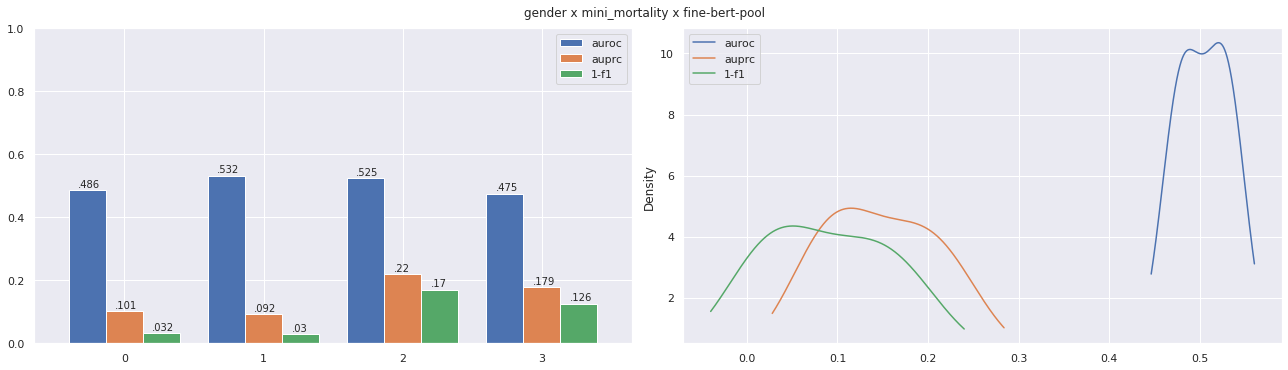

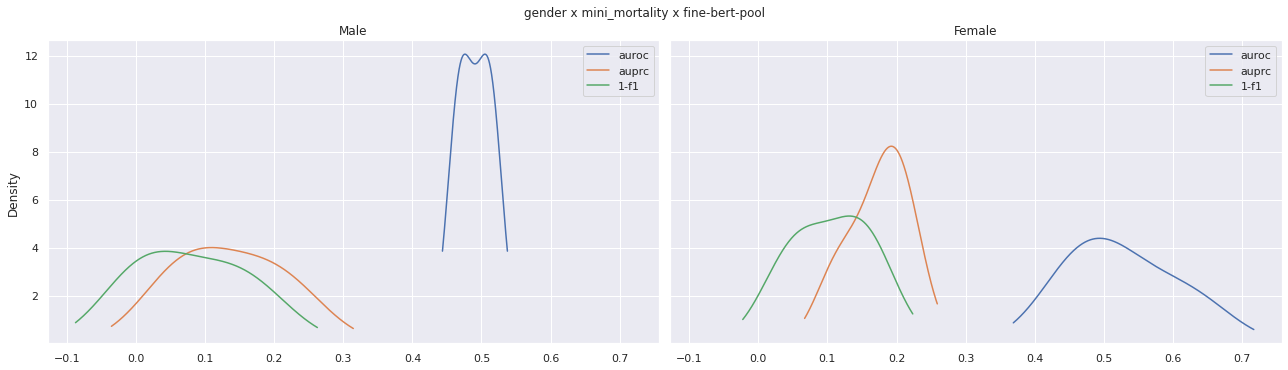

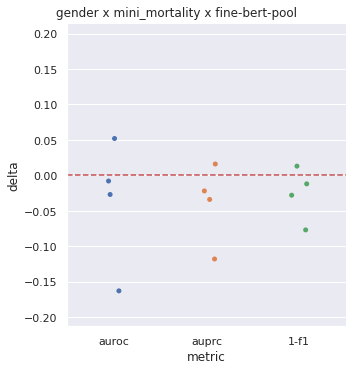

In [15]:
#testing testing
gender_analysis(input_path,"mini_mortality","TEXT","EXPIRE", "FINE-BERT-POOL", output_path, tmp_path)
# ethnicity_binary_analysis(input_path,"mini_mortality","TEXT","EXPIRE", "BOW-bin", output_path, tmp_path)
# ethnicity_analysis(input_path,"mini_mortality","TEXT","EXPIRE", "BOW-bin", output_path, tmp_path)

In [13]:
# get_cached_results(output_path+"gender_mini_mortality_bow-bin.pkl")
# get_cached_results(output_path+"ethnicity-binary_mini_mortality_bow-bin.pkl")
# get_cached_results(output_path+"ethnicity_mini_mortality_bow-bin.pkl")
                                

# Outcomes

In [ ]:
MODEL="BOW-FREQ"

## mortality 

In [ ]:
# mortality_dataset="mortality"
mortality_dataset="mini_mortality"

loaded cached features
train set:  (3198, 118636)
loaded cached results | seed: 0
loaded cached results | seed: 1
loaded cached results | seed: 2
loaded cached results | seed: 3


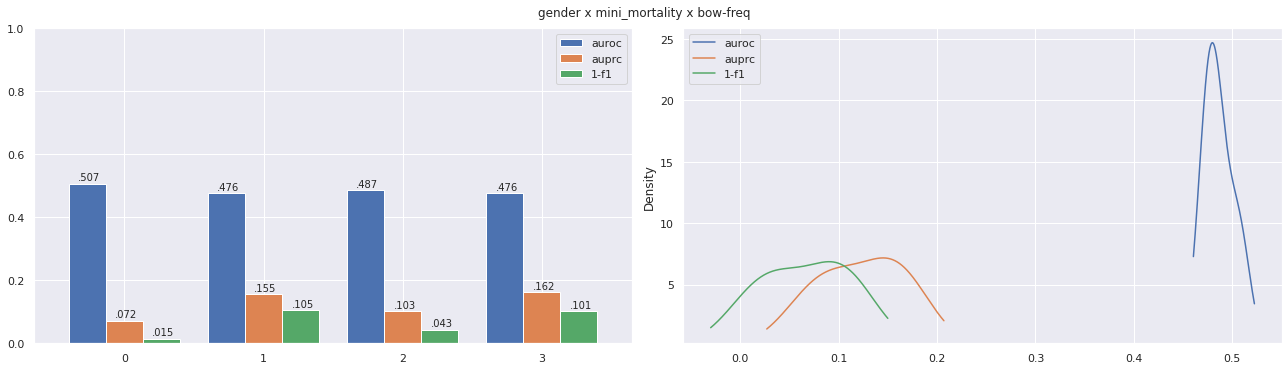

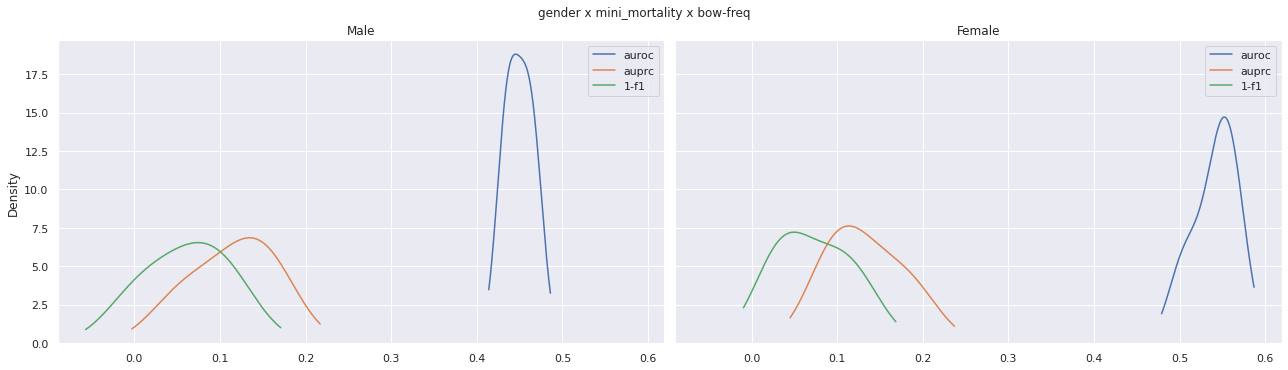

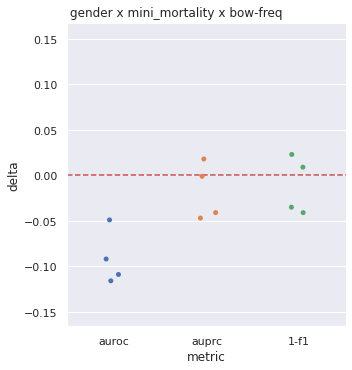

In [ ]:
gender_analysis(input_path, mortality_dataset,"TEXT","EXPIRE", MODEL, output_path, tmp_path)

In [ ]:
ethnicity_binary_analysis(input_path, mortality_dataset, "TEXT", "EXPIRE", MODEL, output_path, tmp_path)

WHITE: 648 | others: 353

batch:1/16 (size: 200)[max len: 510]

batch:2/16 (size: 200)[max len: 510]

batch:3/16 (size: 200)[max len: 510]

batch:4/16 (size: 200)[max len: 510]

batch:5/16 (size: 200)[max len: 510]

batch:6/16 (size: 200)[max len: 510]

batch:7/16 (size: 200)[max len: 510]

batch:8/16 (size: 200)[max len: 510]

batch:9/16 (size: 200)[max len: 510]

batch:10/16 (size: 200)[max len: 510]

batch:11/16 (size: 200)[max len: 510]

batch:12/16 (size: 200)[max len: 510]

batch:13/16 (size: 200)[max len: 510]

batch:14/16 (size: 200)[max len: 510]

batch:15/16 (size: 200)[max len: 510]

batch:16/16 (size: 198)[max len: 510]

batch:1/4 (size: 200)[max len: 510]

batch:2/4 (size: 200)[max len: 510]

batch:3/4 (size: 200)[max len: 510]

batch:4/4 (size: 48)[max len: 510]

batch:1/2 (size: 200)[max len: 510]

batch:2/2 (size: 153)[max len: 510]

batch:1/6 (size: 200)[max len: 510]

batch:2/6 (size: 200)[max len: 510]

batch:3/6 (size: 200)[max len: 510]

batch:4/6 (size: 200)[max l

In [ ]:
ethnicity_analysis(input_path, mortality_dataset, "TEXT", "EXPIRE", MODEL, output_path, tmp_path)

## readmissions


In [ ]:
# readmissions_dataset="readmissions"
readmissions_dataset="mini_readmissions"

In [ ]:
gender_analysis(input_path, readmissions_dataset,"TEXT","READMISSION", MODEL, "Readmission x Gender")

In [ ]:
ethnicity_binary_analysis(input_path, readmissions_dataset, "TEXT","READMISSION", "BERT_POOL", "Readmission x Binary Ethnicity")

In [ ]:
ethnicity_analysis(input_path, readmissions_dataset,"TEXT","READMISSION", "BERT_POOL", "Readmission x Ethnicity")

# Manual Analysis

In [ ]:
# # df_readmission = pd.read_csv(out_data_path+"readmissions.csv",sep="\t", header=None, names=["READMISSION","TEXT","GENDER","ETHNICITY_LABEL","ETHNICITY_BINARY"])
# df_readmission

In [ ]:
# x_label="TEXT"
# y_label="READMISSION"
# feature_type="BOW-freq"
# df=df_readmission
# #GENDER
# # df_res, df_res_M, df_res_F, df_res_delta = gender_outcome_anaylsis(df, x_label, y_label, feature_type)
# #ETHNICITY
# df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_res_delta_W, df_res_delta_N,df_res_delta_A, df_res_delta_H  = ethinicity_outcome_anaylsis(df, x_label, y_label, feature_type)





In [ ]:
# title="test"
# #GENDER
# # gender_plot_performance(df_res, title)
# # gender_plot_densities(df_res_M, df_res_F, title)
# # gender_plot_deltas(df_res_delta, title)
# #ETHNICITY
# ethinicity_plot_performance(df_res, title)
# ethnicity_plot_densities(df_res_W, df_res_N, df_res_A, df_res_H, title)
# ethinicity_plot_deltas(df_res_delta_W, df_res_delta_N,df_res_delta_A,df_res_delta_H, title)